In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicyDemoAdaptiveAlpha, PolicySimulator, createEnv

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           4
Bandwidth:              1000
M List:                 [2, 3]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


(100, 4)
(100, 4)


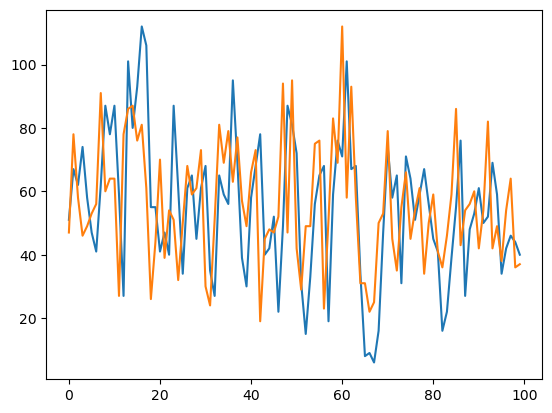

In [3]:
env.reset()
env.selectMode(mode="test", type="data")
u_record = []
u_predicted_record = []
for _ in range(100):
    env.updateStates()
    u, u_predicted = env.getStates()
    u_record.append(u)
    u_predicted_record.append(u_predicted)

u_record = np.array(u_record)
u_predicted_record = np.array(u_predicted_record)
print(u_record.shape)
print(u_predicted_record.shape)
plt.plot(u_record[:,0].flatten())
plt.plot(u_predicted_record[:,0].flatten())
plt.show()

avg_reward_mdp: 0.0058302697899836435, avg_reward_adaptive: 0.017440471172701127


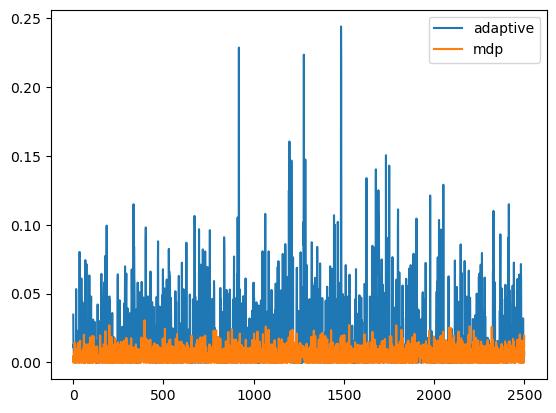

In [4]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernel_config{configIdx}.pkl', 'rb') as f:
    mdpPolicy = pickle.load(f)
adaptiveAlphaPolicy = PolicyDemoAdaptiveAlpha(envParams)

# ==== Prepare Simulator====
mode = "test"
type = "data"
num_epochs = 2500
obvMode = "perfect" # "perfect" or "predicted"
policySimulator = PolicySimulator(mdpPolicy, env)
rewardRecord_mdp = policySimulator.runSimulation(mdpPolicy, obvMode=obvMode, num_epochs=num_epochs, mode=mode, type=type)
rewardRecord_adaptive = policySimulator.runSimulation(adaptiveAlphaPolicy, obvMode=obvMode, num_epochs=num_epochs, mode=mode, type=type)

print(f"avg_reward_mdp: {np.mean(rewardRecord_mdp)}, avg_reward_adaptive: {np.mean(rewardRecord_adaptive)}")

plt.plot(rewardRecord_adaptive, label="adaptive")
plt.plot(rewardRecord_mdp, label="mdp")
plt.legend()
plt.show()